In [2]:
!pip install matplotlib
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.7 MB/s eta 0:00:00a 0:00:01


In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. pandas 버전 확인
print(pd.__version__)

# 2. 파일 불러오기 (인코딩 문제 해결)
df = pd.read_csv('last 최종.csv', encoding='cp949', low_memory=False)

# 3. 단가 칼럼 값 확인
print(df['단가'].unique())

# 4. 단가 변환 (공백, $, 쉼표 제거 후 숫자로 변환)
df['단가'] = df['단가'].astype(str).str.replace('[\$,]', '', regex=True).str.strip()
df['단가'] = pd.to_numeric(df['단가'], errors='coerce')

# 5. 변환 결과 확인
print(df['단가'].dtype)
print(df['단가'].head())

# 1. 데이터 불러오기 및 전처리
df = pd.read_csv('last 최종.csv', encoding='euc-kr')

# 날짜 관련 칼럼 제거
df.drop(columns=['주문날짜', '입고날짜', '유통기한'], inplace=True)

# 단가 처리: '$'를 제거하고 float로 변환
df['단가'] = df['단가'].str.replace('$', '', regex=False).astype(float)

# 주문량, 판매량, 재고손실을 float 형으로 변환
df['주문량'] = df['주문량'].astype(float)
df['판매량'] = df['판매량'].astype(float)
df['재고손실'] = df['재고손실'].astype(float)

<>:22: SyntaxWarning: invalid escape sequence '\$'
<>:22: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_1236/2497549895.py:22: SyntaxWarning: invalid escape sequence '\$'
  df['단가'] = df['단가'].astype(str).str.replace('[\$,]', '', regex=True).str.strip()


2.2.3
['$3.00 ' '$2.00 ' '$1.80 ' '$12.00 ' '$4.45 ' '$20.00 ' '$2.50 '
 '$10.00 ' '$2.80 ' '$15.50 ' '$7.00 ' '$5.00 ' '$4.75 ' '$1.90 ' '$2.95 '
 '$7.60 ' '$5.50 ' '$8.00 ' '$1.50 ' '$6.30 ' '$6.20 ' '$8.90 ' '$4.50 '
 '$6.50 ' '$4.00 ' '$6.00 ' '$2.10 ' '$30.00 ' '$1.00 ' '$3.50 ' '$2.65 '
 '$0.90 ' '$2.40 ' '$9.00 ' '$11.60 ' '$7.20 ' '$4.70 ' '$3.85 ' '$9.50 '
 '$2.30 ' '$5.90 ' '$1.75 ' '$5.20 ' '$2.90 ' '$7.50 ' '$0.80 ' '$20.50 '
 '$2.45 ' '$25.30 ' '$53.82 ' '$25.00 ' '$14.90 ' '$18.00 ' '$1.20 '
 '$15.00 ' '$4.10 ' '$4.80 ' '$11.90 ' '$10.30 ' '$11.80 ' '$3.10 '
 '$31.00 ' '$9.20 ' '$4.40 ' '$3.25 ' '$4.20 ' '$0.20 ' '$9.75 ' '$2.85 '
 '$3.20 ' '$6.35 ' '$21.00 ' '$4.60 ' '$2.75 ' '$1.60 ' '$10.50 ' '$1.70 '
 '$11.50 ' '$25.25 ' '$2.35 ' '$1.45 ' '$6.10 ' '$2.55 ' '$2.70 ' '$5.70 '
 '$4.30 ' '$12.50 ' '$4.35 ' '$6.25 ' '$30.50 ' '$3.40 ' '$3.90 ' '$6.80 '
 '$5.80 ' '$6.15 ' '$15.31 ' '$7.10 ' '$4.25 ' '$51.17 ' '$98.43 '
 '$6.70 ' '$5.30 ' '$4.90 ' '$2.48 ' '$42.58 ' '$13.99 

/tmp/ipykernel_1236/2497549895.py:30: DtypeWarning: Columns (0,1,2,6,7,8,9,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('last 최종.csv', encoding='euc-kr')


In [14]:
# 재고손실 재계산: (주문량 - 판매량)
df['재고손실'] = df['주문량'] - df['판매량']

# 결측치 확인 및 제거
print("결측치 개수:\n", df.isnull().sum())
df = df.dropna(axis=1, how='all')
print("결측치 제거 후 데이터 크기:", df.shape)

# 원본 데이터에서 그룹화에 사용할 칼럼(제품명, 주문량, 판매량)을 보존
df_for_grouping = df[['제품명', '주문량', '판매량']].copy()

# 2. 머신러닝 학습용 데이터 준비 (제품명은 식별자로 제외)
# 제품명을 제외한 나머지 데이터에서 '분류'와 '업체명' 칼럼에 대해 One-Hot 인코딩
df_proc = df.drop(columns=['제품명'])
df_encoded = pd.get_dummies(df_proc, columns=['분류', '업체명'], drop_first=True)

# 특성과 타겟 설정  
# 타겟: '판매량'
# 특성: '주문량', '단가' 등 (재고손실은 이미 주문량-판매량이므로 타겟에 포함하지 않음)
features = df_encoded.drop(['판매량', '재고손실'], axis=1)
target = df_encoded['판매량']

# 3. 데이터 분할 (훈련:테스트 = 80:20)
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.2,
                                                    random_state=42)

# 4. RandomForestRegressor 모델 학습 및 예측
model = RandomForestRegressor(random_state=42,n_jobs=-1)
model.fit(X_train, y_train)

결측치 개수:
 제품명                 949575
분류                  949675
업체명                 949575
주문량                 949575
판매량                 949575
재고손실                949575
단가                  949575
과잉재고(남은재고*단가)       949575
선호도(평균판매량/ 평균재고)    949575
dtype: int64
결측치 제거 후 데이터 크기: (1048575, 9)


ValueError: could not convert string to float: '$0.00 '

In [13]:
# 주문량, 판매량, 재고손실을 float 형으로 변환
df['주문량'] = df['주문량'].astype(float)
df['판매량'] = df['판매량'].astype(float)
df['재고손실'] = df['재고손실'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   제품명               99000 non-null  object 
 1   분류                98900 non-null  object 
 2   업체명               99000 non-null  object 
 3   주문량               99000 non-null  float64
 4   판매량               99000 non-null  float64
 5   재고손실              99000 non-null  float64
 6   단가                99000 non-null  float64
 7   과잉재고(남은재고*단가)     99000 non-null  object 
 8   선호도(평균판매량/ 평균재고)  99000 non-null  object 
dtypes: float64(4), object(5)
memory usage: 72.0+ MB


In [17]:
print(df['단가'].isnull().sum())  # NaN 개수 확인
print(df[df['단가'].isnull()])  # NaN이 있는 행 출력
df = df.dropna(subset=['단가'])

949575
         제품명   분류  업체명  주문량  판매량  재고손실  단가 과잉재고(남은재고*단가) 선호도(평균판매량/ 평균재고)
99000    NaN  NaN  NaN  NaN  NaN   NaN NaN           NaN              NaN
99001    NaN  NaN  NaN  NaN  NaN   NaN NaN           NaN              NaN
99002    NaN  NaN  NaN  NaN  NaN   NaN NaN           NaN              NaN
99003    NaN  NaN  NaN  NaN  NaN   NaN NaN           NaN              NaN
99004    NaN  NaN  NaN  NaN  NaN   NaN NaN           NaN              NaN
...      ...  ...  ...  ...  ...   ...  ..           ...              ...
1048570  NaN  NaN  NaN  NaN  NaN   NaN NaN           NaN              NaN
1048571  NaN  NaN  NaN  NaN  NaN   NaN NaN           NaN              NaN
1048572  NaN  NaN  NaN  NaN  NaN   NaN NaN           NaN              NaN
1048573  NaN  NaN  NaN  NaN  NaN   NaN NaN           NaN              NaN
1048574  NaN  NaN  NaN  NaN  NaN   NaN NaN           NaN              NaN

[949575 rows x 9 columns]


In [20]:
df[:5]

,제품명,분류,업체명,주문량,판매량,재고손실,단가,Unnamed: 10,Unnamed: 11,Unnamed: 12,과잉재고(남은재고*단가),선호도(평균판매량/ 평균재고),Unnamed: 15
0,Peas,Fruits & Vegetables,Meedoo,68.0,96.0,-28.0,3.00,NaN,NaN,NaN,$0.00,-3.428571429,NaN
1,Rice Flour,Grains & Pulses,Livetube,71.0,24.0,47.0,2.00,NaN,NaN,NaN,$0.00,#REF!,NaN
2,Cucumber,Fruits & Vegetables,Yabox,9.0,33.0,-24.0,1.80,NaN,NaN,NaN,$0.00,#REF!,NaN
3,Green Coffee,Beverages,Aibox,93.0,88.0,5.0,12.00,NaN,NaN,NaN,$0.00,#REF!,NaN
4,Pear,Fruits & Vegetables,Cogidoo,5.0,62.0,-57.0,4.45,NaN,NaN,NaN,$0.00,#REF!,NaN


In [ ]:
# 테스트셋에 대한 예측
y_pred = model.predict(X_test)

# 모델 성능 평가
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("모델 성능 평가:")
print("MAE: {:.2f}".format(mae))
print("RMSE: {:.2f}".format(rmse))
print("R²: {:.2f}".format(r2))

In [2]:
def predict_adjustment_for_product(product_name, original_df, encoded_df, model):
    """
    입력받은 제품명(product_name)을 기준으로
    원본 데이터(original_df)와 인코딩된 데이터(encoded_df)에서
    해당 제품의 모든 샘플에 대해 평균값(대표값)을 계산한 후,
    모델 예측(예측 판매량)과 평균 주문량의 차이(조정량)를 산출합니다.
    
    반환:
      predicted_sale: 예측 판매량 (float)
      avg_current_order: 평균 현재 주문량 (float)
      adjustment: 조정량 (예측 판매량 - 평균 주문량)
    """
    # 1. 원본 데이터에서 해당 제품의 모든 행을 필터링
    product_data = original_df[original_df['제품명'] == product_name]
    if product_data.empty:
        print("해당 제품명을 가진 데이터가 없습니다.")
        return None, None, None
    
    # 2. 해당 제품의 평균 주문량 계산
    avg_current_order = product_data['주문량'].mean()
    
    # 3. 인코딩된 데이터에서도 해당 제품 행을 선택 (원본 인덱스를 이용)
    product_encoded = encoded_df.loc[product_data.index]
    if product_encoded.empty:
        print("인코딩된 데이터에서 해당 제품을 찾을 수 없습니다.")
        return None, None, None
    
    # 4. '판매량'과 '재고손실' 컬럼을 제외한 나머지 feature들의 평균값 계산 (Series)
    features_avg = product_encoded.drop(['판매량', '재고손실'], axis=1).mean()

    # DataFrame으로 변환하여 원래 사용했던 피처 이름을 그대로 사용
    features_df = pd.DataFrame([features_avg], columns=product_encoded.drop(['판매량', '재고손실'], axis=1).columns)

    # 5. 학습된 모델로 예측 (DataFrame을 입력으로 전달)
    predicted_sale = model.predict(features_df)[0]

    
    # 6. 조정값 계산: (예측 판매량 - 평균 주문량)
    adjustment = predicted_sale - avg_current_order
    
    return predicted_sale, avg_current_order, adjustment

# 예시 사용:
# model, df, df_encoded는 이전에 생성된 변수(모델 학습 및 전처리 완료)라고 가정합니다.
product_name_input = input("제품명을 입력하세요: ").strip()

predicted_sale, avg_current_order, adjustment = predict_adjustment_for_product(
    product_name_input, df, df_encoded, model
)

if predicted_sale is not None:
    print(f"\n제품명: {product_name_input}")
    print(f"평균 현재 주문량: {np.ceil(avg_current_order)}")
    print(f"모델 예측 평균 판매량(추천 주문량): {np.ceil(predicted_sale)}")
    if adjustment > 0:
        print(f"따라서 주문량을 {np.ceil(adjustment)} 만큼 늘려야 합니다.")
    elif adjustment < 0:
        print(f"따라서 주문량을 {np.ceil(-adjustment)} 만큼 줄여야 합니다.")
    else:
        print("현재 주문량이 최적 주문량과 동일합니다.")


제품명을 입력하세요:  Peas


NameError: name 'df_encoded' is not defined

---
<br>

/tmp/ipykernel_1676/3744256936.py:36: UserWarning: Glyph 52852 (\N{HANGUL SYLLABLE KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1676/3744256936.py:36: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1676/3744256936.py:36: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1676/3744256936.py:36: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1676/3744256936.py:36: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1676/3744256936.py:36: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1676/3744256936.py:36: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  plt.tight_lay

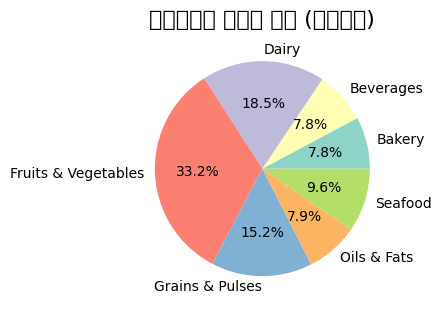

R-squared (알제곱) - 재고손실 예측: 0.6321680324722658

예측값과 실제값 - 재고손실 예측:
                   제품명  실제 재고손실    예상 재고손실
1054       White Sugar      -52 -31.510220
28607              Cod       24  28.748914
30862        Rye Bread      -16 -28.421012
37766            Peach      -63 -52.808509
45263      Bread Flour       33   9.177890
55242       Sesame Oil       27  -2.852775
95554  Sourdough Bread      -14 -15.155246
24021      Bell Pepper      -37 -44.649143
53156        Rye Bread       -7  32.638333
9922     Sunflower Oil      -64 -40.651001
Mean Absolute Error (MAE) - 주문량 예측: 3.6943527411870933

예측값과 제품명 - 주문량 예측:
               제품명     예상 주문량
0      White Sugar  80.000000
1              Cod  63.000000
2        Rye Bread  47.000000
3            Peach  70.000000
4      Bread Flour  38.608333
5       Sesame Oil  29.000000
6  Sourdough Bread  58.033333
7      Bell Pepper  52.080000
8        Rye Bread  73.381667
9    Sunflower Oil  83.000000


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.font_manager as fm
import os



#-------------------------------------------------------------- 데이터 불러오기 ---------------------------------------------------------------------
 
df = pd.read_csv("last (2).csv", encoding='euc-kr', parse_dates=['주문날짜'])  # 경로 알맞게 넣기

#-------------------------------------------------------------- 카테고리별 비율 계산 ---------------------------------------------------------------------

# 카테고리별 판매량 합계 계산
category_sales = df.groupby('분류')['판매량'].sum()

# 전체 판매량 계산
total_sales = df['판매량'].sum()

# 카테고리별 판매량 비율 계산
category_ratio = round((category_sales / total_sales) * 100, 1)

# 파이차트: 카테고리별 판매량 비율
plt.figure(figsize=(4.4, 4.4))  # 파이차트 크기도 4.4로 설정
category_ratio.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('Set3', n_colors=len(category_ratio)))
plt.title('카테고리별 판매량 비율 (파이차트)', fontsize=16)
plt.ylabel('')  # y축 레이블 제거
plt.tight_layout()
plt.show()

#-------------------------------------------------------------- 그래표안나올때 폰트오류문제 해결 ---------------------------------------------------------------------



#-------------------------------------------------------'단가' 컬럼에서 '$'와 공백,결측치를 제거하고 숫자로 변환-------------------------------------------------------------

df['단가'] = df['단가'].replace({r'\$': '', ',': '', ' ': ''}, regex=True)  # '$'와 ',' 제거
df['단가'] = pd.to_numeric(df['단가'], errors='coerce')  # 숫자로 변환, 변환 실패 시 NaN 처리

# 결측치 처리: '단가' 컬럼에서 결측치가 있는 행 제거
df.dropna(subset=['단가', '재고손실'], inplace=True)  # '단가'와 '재고손실' 모두 결측치 처리

#----------------------------------------------------------------날짜데이터 정리및 분석 전처리 과정--------------------------------------------------------------------------

# 날짜 컬럼을 datetime 형식으로 변환
df['주문날짜'] = pd.to_datetime(df['주문날짜'], errors='coerce')  # 날짜 형식으로 변환

# '주문날짜'를 기준으로 '년월' 컬럼을 생성
df['년월'] = df['주문날짜'].dt.to_period('M')  # 월 단위로 period 변환

# '년월' 컬럼에서 '년'과 '월'을 추출
df['년'] = df['년월'].dt.year  # '년월'에서 '년' 추출
df['월'] = df['년월'].dt.month  # '년월'에서 '월' 추출

#----------------------------------------------------------------날짜데이터 정리및 분석 전처리 과정--------------------------------------------------------------------------

####### 첫 번째 모델: 재고손실 예측 (Ridge Regression) #######

# 특성 및 타겟 설정 (첫 번째 모델: 재고손실 예측)
X_ridge = df[['단가', '주문량']]  # 특성: 단가와 주문량
y_ridge = df['재고손실']  # 타겟: 재고손실 (Series 형태로 수정)

# 데이터 표준화
scaler_ridge = StandardScaler()  # 표준화 객체 생성
X_ridge_scaled = scaler_ridge.fit_transform(X_ridge)  # 특성 데이터 표준화

# 훈련 세트와 테스트 세트로 나누기 (80% 훈련, 20% 테스트)
X_train_ridge, X_test_ridge, y_train_ridge, y_test_ridge, X_train_index, X_test_index = train_test_split(
    X_ridge_scaled, y_ridge, df.index, test_size=0.2, random_state=42
)

# Ridge Regression 모델 (L2 정규화) 사용
ridge_model = Ridge(alpha=1.0)  # alpha는 정규화 강도
ridge_model.fit(X_train_ridge, y_train_ridge)  # 모델 훈련

# 예측값 계산
y_pred_ridge = ridge_model.predict(X_test_ridge)

# R² 값 계산
r2_ridge = r2_score(y_test_ridge, y_pred_ridge)  # R² 값 계산
print(f"R-squared (알제곱) - 재고손실 예측: {r2_ridge}")

# 예측값과 실제값 - 재고손실 예측 (제품명 포함)
df_test_ridge = pd.DataFrame({
    '제품명': df.loc[X_test_index, '제품명'],  # 인덱스를 사용하여 제품명 매칭
    '실제 재고손실': y_test_ridge,
    '예상 재고손실': y_pred_ridge
})
print("\n예측값과 실제값 - 재고손실 예측:")
print(df_test_ridge.head(10))  # 예시로 상위 10개만 출력

####### 두 번째 모델 (랜덤 포레스트) - 주문량 예측 #######

# 특성 선택: '단가', '주문량', '년', '월', '제품명'
X_forest = df[['단가', '주문량', '년', '월']]
y_forest = df['판매량']  # 예측할 값은 '주문량'

# 데이터 표준화
scaler_forest = StandardScaler()  # 표준화 객체 생성
X_forest_scaled = scaler_forest.fit_transform(X_forest)

# 훈련 세트와 테스트 세트로 나누기
X_train_forest, X_test_forest, y_train_forest, y_test_forest, X_train_index, X_test_index = train_test_split(
    X_forest_scaled, y_forest, df.index, test_size=0.2, random_state=42
)

# 랜덤 포레스트 모델 설정
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train_forest, y_train_forest)

# 테스트 세트 예측
y_pred_forest = forest_model.predict(X_test_forest)

# 예측 결과 평가 (MAE)
mae_forest = mean_absolute_error(y_test_forest, y_pred_forest)
print(f"Mean Absolute Error (MAE) - 주문량 예측: {mae_forest}")

# 예측값과 제품명 - 주문량 예측 (제품명 포함)
df_test_forest = df.loc[X_test_index]  # X_test_index를 통해 실제 데이터 가져오기
df_test_forest['예상 주문량'] = y_pred_forest

# 예측값과 실제값 - 주문량 예측
result_df_forest = df_test_forest[['제품명', '예상 주문량']].reset_index(drop=True)
print("\n예측값과 제품명 - 주문량 예측:")
print(result_df_forest.head(10))  # 예시로 상위 10개만 출력




In [63]:
# 테스트셋에 대한 예측
y_pred = model.predict(X_test_forest)

# 모델 성능 평가
mae = mean_absolute_error(y_test_forest, y_pred_forest)
rmse = np.sqrt(mean_squared_error(y_test_forest, y_pred_forest))
r2 = r2_score(y_test_forest, y_pred_forest)

print("모델 성능 평가:")
print("MAE: {:.2f}".format(mae))
print("RMSE: {:.2f}".format(rmse))
print("R²: {:.2f}".format(r2))

ValueError: Feature shape mismatch, expected: 358, got 4

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error



# -------------------------------------------------------------1. 데이터 불러오기 및 전처리-----------------------------------------------------------------
df = pd.read_csv('last (2).csv', encoding='euc-kr')

# 날짜 관련 칼럼 제거
df.drop(columns=['주문날짜', '입고날짜', '유통기한'], inplace=True)

#'단가' 컬럼에서 '$'와 공백,결측치를 제거하고 숫자로 변환
df['단가'] = df['단가'].replace({r'\$': '', ',': '', ' ': ''}, regex=True)  # '$'와 ',' 제거
df['단가'] = pd.to_numeric(df['단가'], errors='coerce')  # 숫자로 변환, 변환 실패 시 NaN 처리

# 주문량, 판매량, 재고손실을 float 형으로 변환
df['주문량'] = df['주문량'].astype(float)
df['판매량'] = df['판매량'].astype(float)
df['재고손실'] = df['재고손실'].astype(float)

# 재고손실 재계산: (주문량 - 판매량)
df['재고손실'] = df['주문량'] - df['판매량']
df_encoded = df_encoded.astype(float)
df_encoded['가격_총합'] = df_encoded['단가'] * df_encoded['주문량']
df_encoded['판매비율'] = df_encoded['판매량'] / df_encoded['주문량']  # 판매율
df_encoded['재고손실율'] = df_encoded['재고손실'] / df_encoded['주문량']  # 재고손실율
df_encoded['단가_로그'] = np.log1p(df_encoded['단가'])  # 로그 변환
df_encoded.fillna(0, inplace=True)  # NaN 값이 발생할 수 있으므로 0으로 대체

# 결측치 확인 및 제거
print("결측치 개수:\n", df.isnull().sum())
df = df.fillna(1)
print("결측치 제거 후 데이터 크기:", df.shape)

# 원본 데이터에서 그룹화에 사용할 칼럼(제품명, 주문량, 판매량)을 보존
df_for_grouping = df[['제품명', '주문량', '판매량']].copy()

# IQR (사분위 범위) 기반 이상치 제거
Q1 = df_encoded.quantile(0.25)
Q3 = df_encoded.quantile(0.75)
IQR = Q3 - Q1
df_encoded = df_encoded[~((df_encoded < (Q1 - 1.5 * IQR)) | (df_encoded > (Q3 + 1.5 * IQR))).any(axis=1)]

# ----------------------------------------------------2. 머신러닝 학습용 데이터 준비 및 학습 예측준비 (제품명은 식별자로 제외)--------------------------------------------------

# 제품명을 제외한 나머지 데이터에서 '분류'와 '업체명' 칼럼에 대해 One-Hot 인코딩
df_proc = df.drop(columns=['제품명'])
df_encoded = pd.get_dummies(df_proc, columns=['분류', '업체명'], drop_first=True)

# 특성과 타겟 설정  
# 타겟: '판매량'
# 특성: '주문량', '단가' 등 (재고손실은 이미 주문량-판매량이므로 타겟에 포함하지 않음)
features = df_encoded.drop(['판매량', '재고손실'], axis=1)
target = df_encoded['판매량']

# 3. 데이터 분할 (훈련:테스트 = 80:20)
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.2,
                                                    random_state=42)



# XGBoost Regressor 모델 생성
model = xgb.XGBRegressor(
    n_estimators=300,        # 트리 개수 증가
    max_depth=6,             # 트리 깊이 증가
    learning_rate=0.03,      # 학습 속도 미세 조정
    min_child_weight=5,      # 리프 노드 크기 조정
    gamma=0.2,               # 가지치기 강화
    subsample=0.7,           # 샘플링 비율 증가
    colsample_bytree=0.8,    # 특성 선택 비율 증가
    reg_lambda=1.5,          # L2 정규화 조정
    reg_alpha=0.5,           # L1 정규화 추가
    random_state=42,
    n_jobs=-1
)

# 모델 학습
model.fit(X_train, y_train)

/home/dmin/venv_dl/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


결측치 개수:
 제품명       0
분류      100
업체명       0
주문량       0
판매량       0
재고손실      0
단가        0
dtype: int64
결측치 제거 후 데이터 크기: (99000, 7)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.2, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=-1, num_parallel_tree=None, ...)

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

# ---------------------------- 1. 데이터 불러오기 및 전처리 ----------------------------

df = pd.read_csv('last (2).csv', encoding='euc-kr')

# 날짜 관련 칼럼 제거
df.drop(columns=['주문날짜', '입고날짜', '유통기한'], inplace=True)

# 단가 변환 (문자 제거 후 숫자로 변환)
df['단가'] = df['단가'].replace({r'\$': '', ',': '', ' ': ''}, regex=True)
df['단가'] = pd.to_numeric(df['단가'], errors='coerce')

# 주문량, 판매량, 재고손실 계산
df['주문량'] = df['주문량'].astype(float)
df['판매량'] = df['판매량'].astype(float)
df['재고손실'] = df['주문량'] - df['판매량']

# 새로운 특성 추가
df['가격_총합'] = df['단가'] * df['주문량']
df['판매비율'] = df['판매량'] / df['주문량']  # 판매율
df['재고손실율'] = df['재고손실'] / df['주문량']  # 재고손실율

# NaN 값 처리
df.fillna(0, inplace=True)

# ---------------------------- 2. 이상치 처리 (IQR 기반 중앙값 대체) ----------------------------
for col in ['단가', '주문량', '가격_총합', '판매량', '재고손실']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    median = df[col].median()
    df[col] = np.where(
        (df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)),
        median,
        df[col]
    )

# ---------------------------- 3. 데이터 인코딩 및 스케일링 ----------------------------
# 원-핫 인코딩
df_proc = df.drop(columns=['제품명'])
df_encoded = pd.get_dummies(df_proc, columns=['분류', '업체명'], drop_first=True)

# 로그 변환 적용
for col in ['단가', '주문량', '가격_총합']:
    df_encoded[col] = np.log1p(df_encoded[col])

# 데이터 표준화 (StandardScaler 적용)
scaler = StandardScaler()
scaled_cols = ['단가', '주문량', '가격_총합', '판매비율', '재고손실율']
df_encoded[scaled_cols] = scaler.fit_transform(df_encoded[scaled_cols])

# 특성과 타겟 설정
features = df_encoded.drop(['판매량', '재고손실'], axis=1)
target = df_encoded['판매량']

# ---------------------------- 4. K-Fold 교차 검증 ----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = []

for train_idx, test_idx in kf.split(features):
    X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]

    # 타겟 값 로그 변환
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)

    # 모델 학습
    model = xgb.XGBRegressor(
        n_estimators=200,        # 트리 개수 줄임
        max_depth=5,             # 트리 깊이 제한
        learning_rate=0.05,      # 학습 속도 조정
        min_child_weight=5,      # 리프 노드 크기 조정
        gamma=0.3,               # 가지치기 강화
        subsample=0.7,           # 샘플링 비율 조정
        colsample_bytree=0.8,    # 특성 선택 비율 조정
        reg_lambda=2.0,          # L2 정규화 증가
        reg_alpha=1.0,           # L1 정규화 증가
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)

    # 모델 평가
    y_pred = model.predict(X_test)
    y_pred = np.expm1(y_pred)  # 로그 변환 복구
    y_test = np.expm1(y_test)  # 로그 변환 복구

    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

# ---------------------------- 5. 결과 출력 ----------------------------
print(f"평균 R² Score: {np.mean(r2_scores):.4f}")
print(f"각 Fold 별 R² Score: {r2_scores}")


평균 R² Score: 0.9931
각 Fold 별 R² Score: [0.9929902246834568, 0.9929548727553612, 0.9934333917612936, 0.992872423523851, 0.9930669875034991]


/home/dmin/venv_dl/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dmin/venv_dl/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dmin/venv_dl/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dmin/venv_dl/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dmin/venv_dl/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  fig.

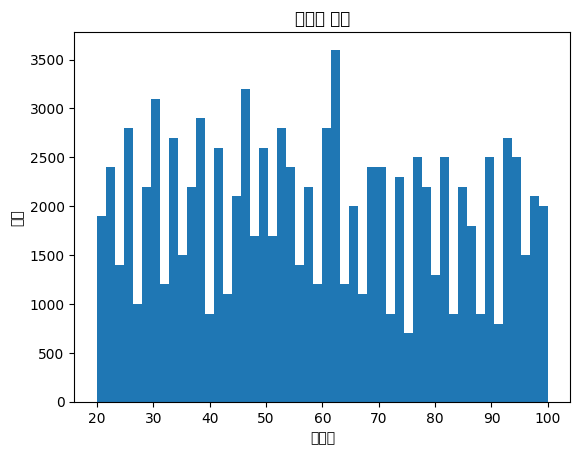

In [18]:
import matplotlib.pyplot as plt

plt.hist(df['판매량'], bins=50)
plt.xlabel('판매량')
plt.ylabel('빈도')
plt.title('판매량 분포')
plt.show()

In [17]:
!fc-list | grep "NanumGothic"

/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf: NanumGothicCoding,나눔고딕코딩:style=Bold
/usr/share/fonts/truetype/nanum/NanumGothic.ttf: NanumGothic,나눔고딕:style=Regular
/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf: NanumGothicCoding,나눔고딕코딩:style=Regular
/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf: NanumGothic,나눔고딕:style=Bold


In [21]:
import matplotlib.font_manager
font_list = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
[matplotlib.font_manager.FontProperties(fname=font).get_name() for font in font_list if 'Nanum' in font]

['NanumBarunGothic',
 'Nanum Pen Script',
 'NanumGothicCoding',
 'NanumMyeongjo Eco',
 'NanumGothic',
 'NanumBarunGothic',
 'NanumMyeongjo',
 'NanumBarunGothic',
 'NanumMyeongjo Eco',
 'NanumSquare_ac',
 'NanumSquare_ac',
 'Nanum Brush Script',
 'NanumMyeongjo Eco',
 'NanumSquare',
 'NanumMyeongjo',
 'NanumSquare',
 'NanumSquare',
 'NanumSquare',
 'NanumMyeongjo YetHangul',
 'NanumSquareRound',
 'NanumGothic Eco',
 'NanumGothic Eco',
 'NanumSquare_ac',
 'NanumSquareRound',
 'NanumGothic',
 'NanumSquareRound',
 'NanumMyeongjo',
 'NanumBarunGothic',
 'NanumGothic Eco',
 'NanumGothic',
 'NanumGothic',
 'NanumGothicCoding',
 'NanumBarunGothic YetHangul',
 'NanumGothic Eco',
 'NanumBarunpen',
 'NanumBarunpen',
 'NanumMyeongjo Eco',
 'NanumSquareRound',
 'NanumSquare_ac']

In [46]:
rm -rf ~/.cache/matplotlib

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/home/dmin/venv_dl/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dmin/venv_dl/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44544 (\N{HANGUL SYLLABLE GEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dmin/venv_dl/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans

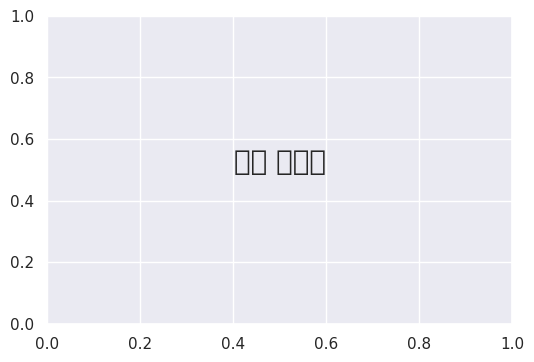

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/home/dmin/venv_dl/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/dmin/venv_dl/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/dmin/venv_dl/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumGothic' not found.
/home/dmin/venv_dl/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/dmin/venv_dl/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  fig.ca

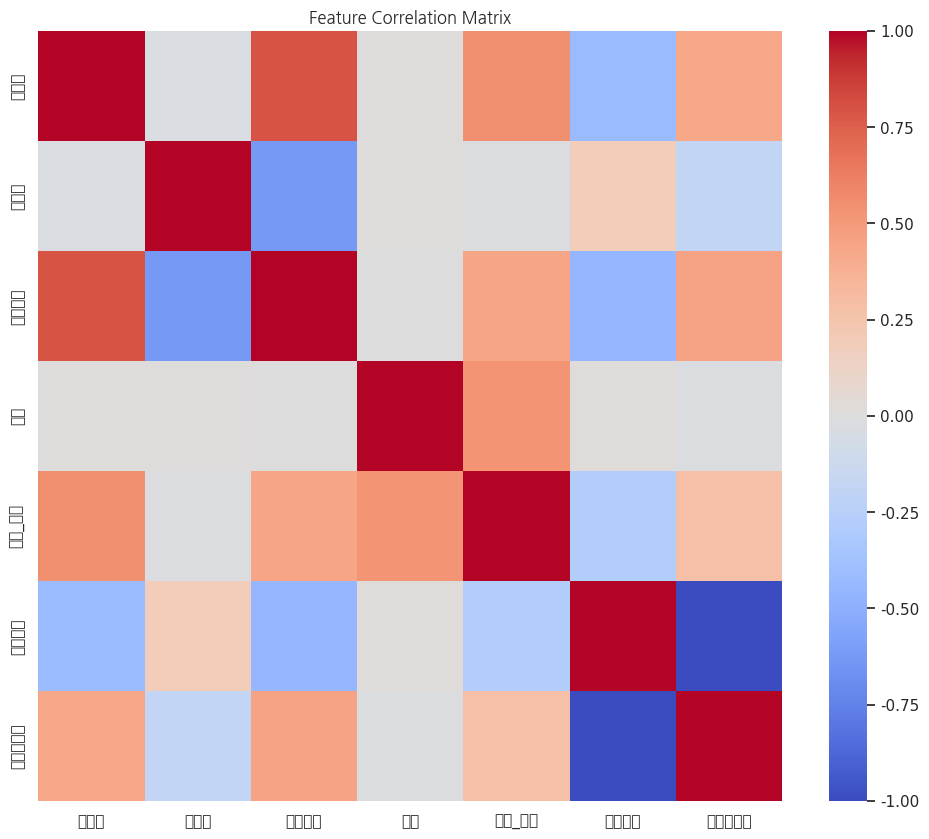

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import numpy as np

# 음수 부호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False  

# NanumGothic 폰트 경로 설정 (설치된 폰트 경로 확인 필요)
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path)

# Matplotlib 기본 폰트 설정
plt.rc('font', family=font_prop.get_name())

# Seaborn 폰트 설정
sns.set(font=font_prop.get_name())

# 숫자형 데이터만 선택
df_numeric = df.select_dtypes(include=[np.number])

# 상관행렬 계산
corr_matrix = df_numeric.corr()

# 한글 테스트 그래프
plt.figure(figsize=(6, 4))
plt.text(0.5, 0.5, "한글 테스트", fontsize=20, ha='center')
plt.show()

# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix", fontproperties=font_prop)
plt.show()


In [67]:
# 테스트셋에 대한 예측
y_pred = model.predict(X_test)

# 모델 성능 평가
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("모델 성능 평가:")
print("MAE: {:.2f}".format(mae))
print("RMSE: {:.2f}".format(rmse))
print("R²: {:.2f}".format(r2))

모델 성능 평가:
MAE: 16.72
RMSE: 19.49
R²: 0.28


In [13]:
feature_importance = model.feature_importances_
print("특성 중요도:\n", feature_importance)

특성 중요도:
 [0.00274981 0.00456813 0.00181762 0.00050832 0.00415029 0.00178028
 0.01236533 0.00063189 0.00336659 0.01129146 0.         0.
 0.         0.         0.01787533 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.01185978 0.         0.         0.         0.
 0.         0.         0.0106677  0.         0.         0.01198244
 0.         0.         0.         0.         0.         0.01596798
 0.         0.         0.01526327 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01147983
 0.01074812 0.         0.         0.         0.         0.01069503
 0.01078341 0.         0.         0.         0.01011089 0.01155972
 0.         0.         0.         0.         0.01111531 0.
 0.01063938 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.